In [1]:
import torch
import torch.nn as nn
import pandas as pd
from d2l import torch as d2l 
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
class FashionMNIST:  #@save
    """The Fashion-MNIST dataset."""
    def __init__(self, resize=(224, 224), split = 'train'):
        self.resize = resize
        self.root = "./../data"
        trans = transforms.Compose([transforms.Resize(resize),
                                    transforms.ToTensor()])
        if split == 'train':
            self.data = torchvision.datasets.FashionMNIST(
            root=self.root, train=True, transform=trans, download=True)
        else:
            self.data = torchvision.datasets.FashionMNIST(
            root=self.root, train=False, transform=trans, download=True)

    # def generate_labels(self, index):
    #     labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
    #           'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    #     return labels[index]
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
        

In [3]:
class CustomDataLoader:
    def __init__(self, dataset, max_epochs, batch_size = 32):
        self.current_index = 0
        self.dataset_len = len(dataset)
        self.batch_size = batch_size
        self.dataset = dataset
        self.max_epochs = max_epochs

    def __iter__(self):
        return self

    def __next__(self):
        if self.current_index > self.dataset_len:
            raise StopIteration
        batch_x = []
        batch_y = []
        
        indices = [random.randint(0, self.dataset_len-1) for _ in range(self.batch_size)]
        for ind in indices:
            batch_x.append(self.dataset[ind][0])
            batch_y.append(self.dataset[ind][1])
        self.current_index += self.batch_size
        return batch_x, batch_y

In [4]:
train_dataset = FashionMNIST(split= 'train')
val_dataset = FashionMNIST(split = 'val') 

In [5]:
train_dataloader = CustomDataLoader(train_dataset, max_epochs = 20, batch_size = 128)
val_dataloader = CustomDataLoader(val_dataset, max_epochs = 20, batch_size = 128)


In [26]:
from torch.nn import functional as F
import torch.optim as optim
class AlexNet(nn.Module):
    def __init__(self, lr):
        super().__init__()
        self.lr = lr
        self.conv1 = nn.Conv2d(1, 96, kernel_size=11, stride = 4, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(3, 2)
        
        self.conv2 = nn.Conv2d(96, 256, kernel_size=5, stride = 1, padding=2)
        self.relu2 = nn.ReLU()
        
        self.maxpool2 = nn.MaxPool2d(3, 2)

        self.conv3 = nn.Conv2d(256, 384, kernel_size=3, stride = 1, padding=1)
        self.relu3 = nn.ReLU()
        
        self.conv4 = nn.Conv2d(384, 384, kernel_size=3, stride = 1, padding=1)
        self.relu4 = nn.ReLU()
        
        self.conv5 = nn.Conv2d(384, 256, kernel_size=3, stride = 1, padding=1)
        self.relu5 = nn.ReLU()
        
        self.maxpool3 = nn.MaxPool2d(3, 2)
        self.dropout = nn.Dropout(0.5)
        self.lin1 = nn.LazyLinear(4096)
        self.relu6 = nn.ReLU()
        self.lin2 = nn.LazyLinear(4096)
        self.relu7 = nn.ReLU()
        self.lin3 = nn.LazyLinear(10)

    def forward(self, X):
        X = torch.stack(X)
        X=X.to(torch.device('cuda:0'))
        a1 = self.conv1(X)
        a1 = self.relu1(a1)
        a2 = self.maxpool1(a1)
        a3 = self.conv2(a2)
        a3 = self.relu2(a3)
        a4 = self.maxpool2(a3)
        a5 = self.conv3(a4)
        a5 = self.relu3(a5)
        a6 = self.conv4(a5)
        a6 = self.relu4(a6)
        a7 = self.conv5(a6)
        a7 = self.relu5(a7)
        a8 = self.maxpool3(a7)
        a9 = torch.flatten(a8, 1)
        a8 = self.dropout(a8)
        a10 = self.lin1(a9)
        a10 = self.relu6(a10)
        a11 = self.lin2(a10)
        a11 = self.relu7(a11)
        a12 = self.lin3(a11)
        res = torch.exp(a12)
        sum_res = res.sum(1, keepdims = True)
        # print(sum_res.shape)
        res = res/sum_res
        
        return res

    def loss(self, Y_pred, Y):
        # softmax loss
        true_val_terms = Y_pred[torch.arange(len(Y)), Y]
        loss = -torch.log(true_val_terms)
        # print("loss: ",loss)
        loss = loss.mean()
        
        return loss

    def configure_optimizers(self):
        return optim.SGD(self.parameters(), self.lr)
        
        

In [27]:
def num_gpus():  #@save
    """Get the number of available GPUs."""
    return torch.cuda.device_count()
def gpu(i=0):  #@save
    """Get a GPU device."""
    return torch.device(f'cuda:{i}')


In [28]:
gpu()

device(type='cuda', index=0)

In [29]:
# trainer
class Trainer:
    def __init__(self, model, train_dataloader, val_dataloader, max_epochs, num_gpu = 0):
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.max_epochs = max_epochs
        self.optim = model.configure_optimizers()  
        self.gpus = [gpu(i) for i in range(min(num_gpu, num_gpus()))]
        if self.gpus:
            model.to(self.gpus[0])
        self.model = model

    def fit(self):
        for epoch in range(self.max_epochs):
            self.fit_epoch(epoch)

    def fit_epoch(self, epoch):
        for idx, batch in enumerate(self.train_dataloader):
            if self.gpus:
                # batch = [a.to(self.gpus[0]) for a in batch]
                self.model
            X, Y = batch
            Y_pred = self.model.forward(X)
            loss = self.model.loss(Y_pred, Y)
            self.optim.zero_grad()
            with torch.no_grad():
                loss.backward()
                self.optim.step()
            print(f"Epoch:{epoch}, iter:{idx}, loss:{loss}")
        with torch.no_grad():
            batch_val_x, batch_val_y = next(iter(self.val_dataloader))
            batch_pred = self.model.forward(batch_val_x)
            val_loss = self.model.loss(batch_pred, batch_val_y)
            print(f"Validation :{epoch}, loss:{val_loss}") 
        self.train_dataloader.current_index = 0
        
# optimizer
class SGD:
    def __init__(self, params, lr):
        self.params = params
        self.lr = lr

    def step(self):
        for param in self.params:
            param-=self.lr*param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

    

In [30]:
net = AlexNet(lr = 0.01)
trainer = Trainer(net, train_dataloader, val_dataloader, 20, 2)
trainer.fit()

Epoch:0, iter:0, loss:2.302189350128174
Epoch:0, iter:1, loss:2.3038179874420166
Epoch:0, iter:2, loss:2.300715446472168
Epoch:0, iter:3, loss:2.3021602630615234
Epoch:0, iter:4, loss:2.302764892578125
Epoch:0, iter:5, loss:2.303455352783203
Epoch:0, iter:6, loss:2.3027970790863037
Epoch:0, iter:7, loss:2.3026163578033447
Epoch:0, iter:8, loss:2.3047595024108887
Epoch:0, iter:9, loss:2.301685094833374
Epoch:0, iter:10, loss:2.3036139011383057
Epoch:0, iter:11, loss:2.30283260345459
Epoch:0, iter:12, loss:2.304476261138916
Epoch:0, iter:13, loss:2.3015785217285156
Epoch:0, iter:14, loss:2.3021461963653564
Epoch:0, iter:15, loss:2.3030858039855957
Epoch:0, iter:16, loss:2.302860736846924
Epoch:0, iter:17, loss:2.303267002105713
Epoch:0, iter:18, loss:2.302896499633789
Epoch:0, iter:19, loss:2.302602767944336
Epoch:0, iter:20, loss:2.303056001663208
Epoch:0, iter:21, loss:2.303732395172119
Epoch:0, iter:22, loss:2.301144599914551
Epoch:0, iter:23, loss:2.3037109375
Epoch:0, iter:24, loss:

In [64]:
# inference
def run_inference(num_samples, visualize = True):
    for i in range(num_samples):
        ind1 = random.randint(0, len(val_dataset))
        io1 = val_dataset[ind1]
        x1, y1 = io1[0], io1[1]
    
        y_pred  = net.forward([x1])
        print(x1.shape)
        x1np = x1.numpy()

        labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
        
        print("True: ",labels[y1])
        plt.imshow(np.squeeze(x1np))
        print("Predicted: ", labels[torch.argmax(y_pred[0])])
        plt.show()

torch.Size([1, 224, 224])
True:  ankle boot
Predicted:  ankle boot


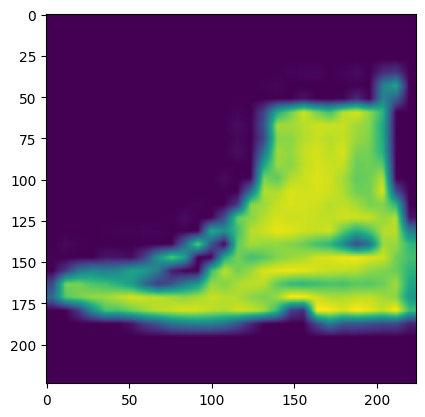

torch.Size([1, 224, 224])
True:  shirt
Predicted:  shirt


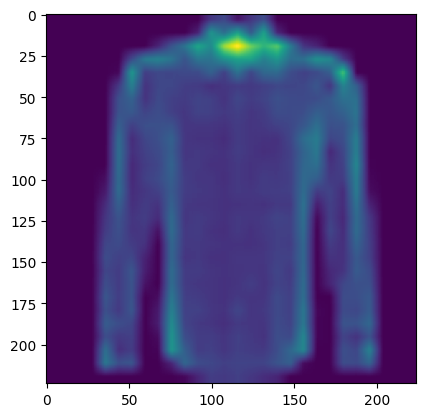

torch.Size([1, 224, 224])
True:  ankle boot
Predicted:  ankle boot


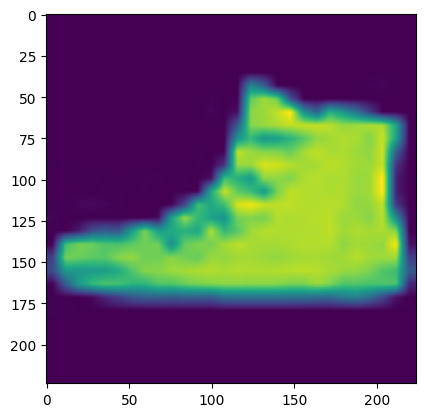

torch.Size([1, 224, 224])
True:  sneaker
Predicted:  sneaker


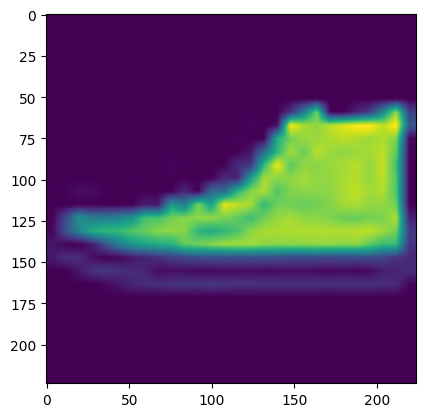

torch.Size([1, 224, 224])
True:  trouser
Predicted:  trouser


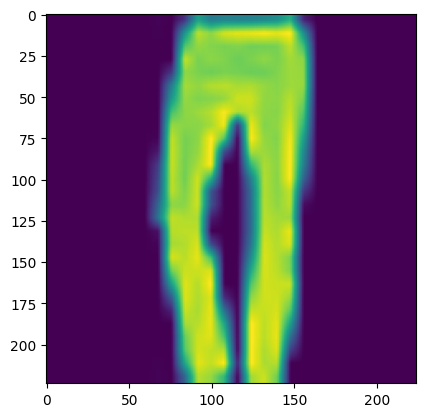

In [65]:
run_inference(5)